In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from dotmap import DotMap
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet

import pnp_mace as pnpm

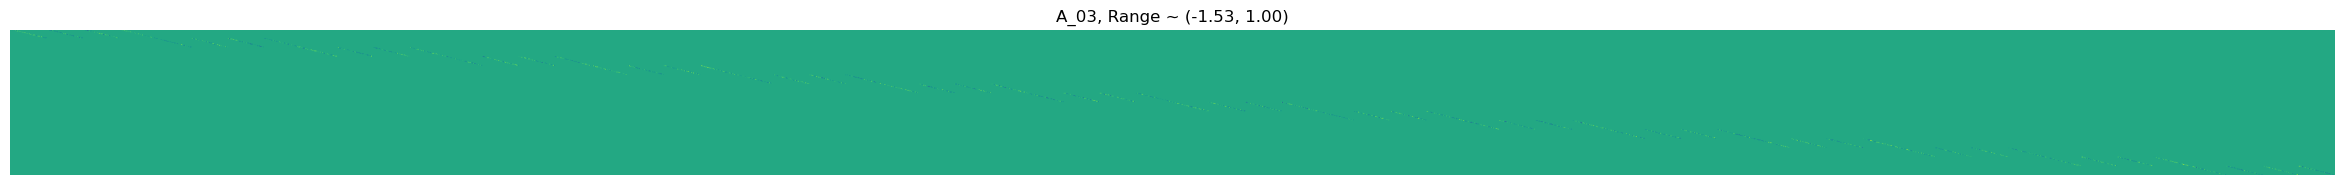

In [57]:
data = loadmat("./data/jelly_fish/Jellyfish_4x4-patches.mat")
A_stacked = data['A'].reshape(64, 256, 4096)
Y = data['y'].reshape(256, 64)

IT = 2
plt.figure(figsize=(30,10))
plt.imshow(A_stacked[IT])
plt.title(f"A_{IT+1:02}, Range ~ ({A_stacked[IT].min():.2f}, {A_stacked[IT].max():.2f})")
plt.axis('off')
plt.show()

In [73]:
s_limit, e_limit = 0,512
phi = A_stacked.reshape(-1, 4096)[s_limit:e_limit]
y = Y.reshape(-1)[s_limit:e_limit]/8


def A(x):
    return phi@x.flatten()


def AT(y):
    return (phi.T@y).reshape(64,64)


step_size = 0.1
forward_agent = pnpm.LinearProxForwardAgent(y, A, AT, step_size)


# Set the denoiser for the prior agent
def denoiser(x, params):
    denoised_x = pnpm.bm3d_method(x, params)
    return denoised_x


prior_agent_method = denoiser

prior_params = DotMap()
prior_params.noise_std = 0.1

prior_agent = pnpm.PriorAgent(prior_agent_method, prior_params)


# Set the denoiser for the prior agent
def denoiser2(x, params):
    denoised_x = denoise_wavelet(x, sigma=0.1)
    return denoised_x


prior_agent_method2 = denoiser2
prior_agent2 = pnpm.PriorAgent(prior_agent_method2, prior_params)

Compute and display one step of forward and prior agents for illustration purposes.

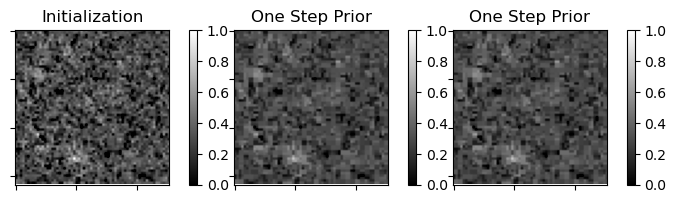

In [74]:
x_init = (phi.T @ y).reshape(64,64)
x_init = x_init/x_init.max()
one_step_forward = forward_agent(np.asarray(x_init))
one_step_prior = prior_agent2(np.asarray(x_init))


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
pnpm.display_image(x_init, title="Initialization", fig=fig, ax=ax[0])
pnpm.display_image(one_step_prior, title="One Step Prior",fig=fig, ax=ax[1])
pnpm.display_image(one_step_prior, title="One Step Prior",fig=fig, ax=ax[2])

Set up the equilibrium problem

Starting Mann iterations
Finished iteration 1 of 20
Finished iteration 2 of 20
Finished iteration 3 of 20
Finished iteration 4 of 20
Finished iteration 5 of 20
Finished iteration 6 of 20
Finished iteration 7 of 20
Finished iteration 8 of 20
Finished iteration 9 of 20
Finished iteration 10 of 20
Finished iteration 11 of 20
Finished iteration 12 of 20
Finished iteration 13 of 20
Finished iteration 14 of 20
Finished iteration 15 of 20
Finished iteration 16 of 20
Finished iteration 17 of 20
Finished iteration 18 of 20
Finished iteration 19 of 20
Finished iteration 20 of 20


e:\Python_VENV\PnP\lib\site-packages\pnp_mace\utils.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


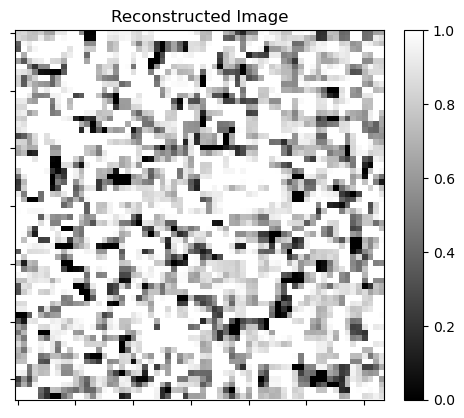

In [77]:
mu0 = 0.5  # Forward agent weight
mu = [.5, .2, .3]
rho = 0.5
num_iters = 20
keep_all_images = False

equil_params = DotMap()
equil_params.mu = mu
equil_params.rho = rho
equil_params.num_iters = num_iters
equil_params.keep_all_images = keep_all_images
equil_params.verbose = True

agents = [forward_agent, prior_agent, prior_agent2]
equil_prob = pnpm.EquilibriumProblem(agents, pnpm.mann_iteration_mace,
                                      equil_params)

init_images = pnpm.stack_init_image(x_init, len(agents))

final_images, residuals, vectors, all_images = equil_prob.solve(init_images)
v_sum = mu[0] * vectors[0] + mu[1] * vectors[1]
i0 = Image.fromarray(final_images[0])

pnpm.display_image(i0, title="Reconstructed Image", cmap="gray")